# 2-Layer Multi-Class Neural Network from scratch
Following [this](https://stackabuse.com/creating-a-neural-network-from-scratch-in-python-multi-class-classification/) tutorial.

The purpose here is to make a Neural Network in Python from scratch to solve multi-class classification problems, for example: classifying hand-draw digits.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset
We'll be manually making a dataset using randomly generated points (you'll understand later). The dataset will have two features and a label (one of three groups):

In [2]:
np.random.seed(42)

group_1 = np.random.randn(700, 2) + np.array([0, -3])
group_2 = np.random.randn(700, 2) + np.array([3, 3])
group_3 = np.random.randn(700, 2) + np.array([-3, 3])

We've created three separate 2-dimensional arrays of size `700 x 2`. Think of each row in the array/matrix as the features for an object classified into that group. The addition of the arrays afterwards moves the centres of the groups to different areas so there is a difference between the groups:  
`group_1` will be centered around `x=0, y=-3`.  
`group_2` will be centered around `x=3, y=3`.  
`group_3` will be centered around `x=-3, y=3`.

Next we need to vertically join these arrays to create our final dataset.

In [7]:
feature_set = np.vstack([group_1, group_2, group_3])  # merge into 2100x2 array
labels = np.array([0]*700 + [1]*700 + [2]*700)  # 2100x1 array of labels

In [23]:
feature_set

array([[ 0.49671415, -3.1382643 ],
       [ 0.64768854, -1.47697014],
       [-0.23415337, -3.23413696],
       ...,
       [-5.38692987,  2.50412183],
       [-1.90269981,  1.43435197],
       [-6.00763234,  3.57117941]])

For multi-class classification problems, we need to define the output label as a vector since the output layer will have three nodes and each node will correspond to one class. What we want is that when an output is predicted, the value of the corresponding node should be 1 while the remaining the nodes should have a value of 0.

In [21]:
vector_labels = np.zeros((2100, 3))
for i in range(2100):
    vector_labels[i, labels[i]] = 1

In [22]:
vector_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

Now let's plot the dataset we just created:

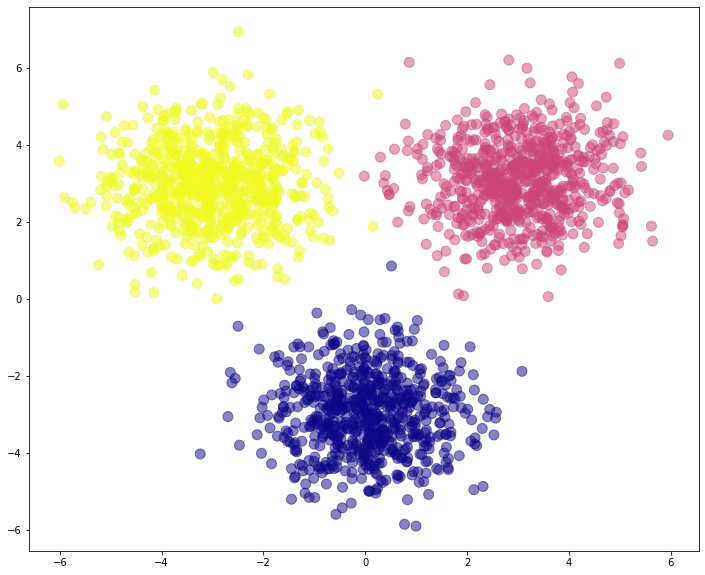

In [26]:
plt.figure(figsize=(12, 10))
plt.scatter(feature_set[:,0], feature_set[:,1], c=labels, cmap='plasma', s=100, alpha=0.5)

Clearly, we have elements belonging to three different classes. Our task is to develop a neural network capable of classifying data into these classes.

## Neural Network with Multiple Output Classes
The neural network that we're going to design has the following architecture:

![Img Alt Text](multi-class-neural-net.png)

Where:  
- $a^{(L)}_j$ is the activation node in layer $L$ at index $j$. For example, the bottom node in the hidden layer is noted as $a^{(1)}_3$.
- $w^{(L)}_{j,k}$ is the weight of the neuron between $a^{(L-1)}_k$ and $a^{(L)}_j$. For example, the blue neuron on the right is noted as $w^{(1)}_{1,0}$ as it connects $x_0$ and and $a^{(1)}_1$
- The grey neurons represent bias.


In general:
<center>
    <font size='4'>
        $
        a^{(L)}_j=\theta(z^{(L)}_j)
        $
    </font>
</center>
Where:
<center>
    <font size='4'>
        $
        z^{(L)}_j=[\sum_{k=0}^{n_{(L-1)}} a^{(L-1)}_k w^{(L)}_{j,k}]+b^{(L-1)}_j
        $
    </font>
</center>  

and $\theta$ is a non-linear function (e.g. ReLU, sigmoid, etc.)

As shown, the neural network has an input with two features, a hidden layer with four nodes, and with an output layer with three nodes. This allows the neural network to solve multi-class problems.

## Softmax and Cross-Entropy Functions
Before moving on, let's briefly talk about the [softmax](https://en.wikipedia.org/wiki/Softmax_function) and [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) functions, which are respectively the most commonly used activation and loss functions for creating a neural network for multi-class classification.

### Softmax Function
We've several options for the activation function at the output layer, and while we could use the sigmoid function (frequently used elsewhere), there is a more convenient activation function in the form of softmax which takes a vector as input and produces another vector of the same length. Since our output contains three nodes, we can consider the output from each node as an element in the vector. The output will be a vector of the same length where all the elements sum to 1. Mathematically, the softmax function can be represented as:
<br><br>
<center>
    <font size='4'>
        $y(\underline{z})_i=$
    </font> <font size='5'>
        $\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$
    </font>
    for $i = 1,...,K$ and $\underline{z}=(z_1,...,z_K)\in \mathbb{R}^K$
</center>

It applies the standard exponential function to each element $z_i$ of the input vector $\underline{z}$ and normalizes these values by dividing by the sum of all these exponentials. Here's the code with an example:

In [27]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum()

nums = np.array([4,5,6])
print(softmax(nums))

[0.09003057 0.24472847 0.66524096]


The softmax activation function has two major advantages over the other activation functions, particularly for multi-class classification problems:
- The softmax function takes a vector as input,
- The softmax function produces an output between 0 and 1.

### Cross-Entropy Function
With the softmax activation function at the output layer, the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) cost function can be used for optimising the cost. However, for the softmax function, a more convenient function exists which is called **cross-entropy**.

Mathematically, the cross-entropy function can be represented as:
<br><br>
<center>
    <font size='4'>
        $H(\underline{y}, \underline{\hat{y}}) = -\sum_i y_i\log{\hat{y}_i}$
    </font>
</center>

The cross-entropy is simply the sum of the products of all the actual probabilities with the negative log of the predicted probabilites. For multi-class classification, the cross-entropy function is known to outperform the gradient descent function.

## Forward Propagation
For the hidden layer output we will still use the sigmoid function as we did previously. The softmax function will be used only for the output layer activations.

### Phase 1: Hidden layer uses sigmoid
In the first phase, we will calculate the output from the hidden layer. For each input datapoint we have two features: `x0` and `x1`. To calculate the output values for each node in the hidden layer, we do the following calculation:
<br><br>
<center>
    <font size='4'>
        $
        a^{(1)}_j=\sigma(z^{(1)}_j)
        $
    </font>
</center>
Where
<center>
    <font size='4'>
        $
        z^{(1)}_j=[\sum_{k=0}^{1} x_k w^{(1)}_{j,k}]+b^{(1)}_j
        $
    </font>
</center>
and
<center>
    <font size='4'>
        $
        \sigma(x)=\frac{1}{1+e^{-x}}
        $
    </font>
</center>

This is the resulting value for the $j$<sup>th</sup> node (from the top, index 0).

### Phase 2: Output layer uses softmax
To calculate the values for the output layer, the values in the hidden layer nodes are treated as inputs. Similar calculations are done here as for the previous layer:
<br><br>
<center>
    <font size='3'>
        $z^{(2)}_0=a^{(1)}_0 w^{(2)}_{0,0}+a^{(1)}_1 w^{(2)}_{0,1}+a^{(1)}_2w^{(2)}_{0,2}+ a^{(1)}_3w^{(2)}_{0,3}+b^{(2)}_0$
        <br><br>
        $z^{(2)}_1=a^{(1)}_0 w^{(2)}_{1,0}+a^{(1)}_1 w^{(2)}_{1,1}+a^{(1)}_2w^{(2)}_{1,2}+ a^{(1)}_3w^{(2)}_{1,3}+b^{(2)}_1$
        <br><br>
        $z^{(2)}_2=a^{(1)}_0 w^{(2)}_{2,0}+a^{(1)}_1 w^{(2)}_{2,1}+a^{(1)}_2w^{(2)}_{2,2}+ a^{(1)}_3w^{(2)}_{2,3}+b^{(2)}_2$
    </font>
</center>

To simplify, let:
<br><br>
<center>
    <font size='3'>
        $
        \boldsymbol{W}^{(2)}=
        \begin{pmatrix}
        w^{(2)}_{0,0} & w^{(2)}_{0,1} & w^{(2)}_{0,2} & w^{(2)}_{0,3} & b^{(2)}_0\\
        w^{(2)}_{1,0} & w^{(2)}_{1,1} & w^{(2)}_{1,2} & w^{(2)}_{1,3} & b^{(2)}_1\\
        w^{(2)}_{2,0} & w^{(2)}_{2,1} & w^{(2)}_{2,2} & w^{(2)}_{2,3} & b^{(2)}_2\\
        \end{pmatrix}
        $
        , 
        $
        \boldsymbol{X}^{(2)}=
        \begin{pmatrix}
        a^{(1)}_0\\a^{(1)}_1\\a^{(1)}_2\\a^{(1)}_3\\1
        \end{pmatrix}
        $
    </font>
</center>
<br><br>
Then $\boldsymbol{W}^{(2)}\boldsymbol{X}^{(2)}$ produces the same set of equations as above.

Here, $z^{(2)}_0$, $z^{(2)}_1$ and $z^{(2)}_2$ will form the vector that we will use as input to the softmax function:
<br><br>
<center>
    <font size='3'>
        $
        \underline{z}^{(2)}=
        \begin{pmatrix}
        z^{(2)}_0\\z^{(2)}_1\\z^{(2)}_2
        \end{pmatrix}
        = \boldsymbol{W}^{(2)}\boldsymbol{X}^{(2)}
        $
    </font>
</center>

To find the output values, we can use the softmax function as follows:
<br><br>
<center>
    <font size='4'>
        $a^{(2)}_j=$
    </font><font size='5'>
        $\frac{e^{z^{(2)}_j}}{\sum_{k=0}^2 e^{z^{(2)}_k}}$
    </font>
</center>

The forward propagation for a neural network with multi-class output is pretty similar for a binary classification neural network. The only difference is here the softmax function is used on the output layer rather than the sigmoid function.

## Backpropagation
The basic idea of backpropagation remains the same: we have to define a cost function and then optimise the cost function by updating the weights such that the cost is minimised. However, unlike with binary classification networks where you could use MSE (Mean Squared Error) as a cost function, here we'll use the cross-entropy function.

Backpropagation is an optimisation problem: we have to find the function minima for our cost function. To find the minima of a function, we can use the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) alrogithm, which can be represented as follows:
<br><br>
<center>
    Repeat until convergence:
    <font size='4'>
        $\{w_j:=w_j-\alpha\frac{\delta}{\delta w_j}J(w_0, w_1, ..., w_n)\}$
    </font>
</center>

Where:  
- $\alpha$ is the *learning rate*
- $J(...)$ is the cost function.

Reminder: our cost function is:
<center>
    <font size='4'>
        $H(\underline{y}, \underline{\hat{y}}) = -\sum_i y_i\log{\hat{y}_i}$
    </font>
</center>

In our neural network, we have an output vector where each element of the vector corresponds to the output from one node in the output layer. The output vector is calculated using the softmax function. If $\underline{a}^{(2)}$ is the vector of the predicted outputs from all output nodes and $\underline{y}$ is the vector of the expected outputs of the corresponding nodes in the output vector, we have to minimise this function:
<br><br>
<center>
    <font size='3'>
        $
        cost(\underline{y}, \underline{a}^{(2)})=-\sum_i y_i \log{a^{(2)}_i}
        $
    </font>
</center>

### Phase 1
In this phase, we need to update the weights in the second layer - these are the weights of the output layer nodes. We know to minimise the cost function, we have to update the weight values such that the cost decreases. To do so, we take the derivatives of the cost function with respect to each weight. Mathematically:
<br><br>
<center>
    <font size='5'>
        $
        \frac{\delta C}{\delta w^{(2)}}=\frac{\delta C}{\delta a^{(2)}}\frac{\delta a^{(2)}}{\delta z^{(2)}}\frac{\delta z^{(2)}}{\delta w^{(2)}}
        $
    </font>
    (By the Chain Rule)
</center>

Remember, $w^{(2)}$ refers to the weights in layer 2 (i.e. output layer).

## Calculus:

### Derivation of Softmax
Because the softmax functions outputs a probability distribution, it is used in the final layer of our neural network - so we need to calculate the derivative and pass it back to the previous layer during backpropagation:
<br><br>
<center>
    <font size='5'>
        $
        \frac{\delta a_i}{\delta z_j}=\frac{\delta \frac{e^{z_i}}{\sum_{k=0}^N e^{z_k}}}{\delta z_j}=\frac{\delta}{\delta z_j}\frac{e^{z_i}}{\sum_{k=0}^N e^{z_k}}
        $
    </font>
</center>

From the [quotient rule](https://en.wikipedia.org/wiki/Quotient_rule) we know that:
<br><br>
<center>
    <font size='4'>
        If $f(x)=\frac{g(x)}{h(x)}$, then $f'(x)=\frac{g'(x)h(x)-h'(x)g(x)}{h(x)^2}$
    </font>
</center>

In our case $g(x)=e^{z_i}$ and $h(x)=\sum_{k=0}^N e^{z_k}$.  
<br>
<font size='4'>
    $
    g'(x)=\frac{\delta}{\delta z_j}g(x)=\frac{\delta}{\delta z_j}e^{z_i}=
    $
    <font size='3'>
        $
        \begin{cases}
            e^{z_j} &\text{if $i=j$} \\
            0 &\text{else}
        \end{cases}
        $
    </font>
    <br><br>
    $
    h'(x)=\frac{\delta}{\delta z_j}h(x)=\frac{\delta}{\delta z_j}\sum_{k=0}^N e^{z_k}=\frac{\delta}{\delta z_j}(e^{z_0}+e^{z_1}+...+e^{z_N})=e^{z_j}
    $
</font>

In $h(x)$, the derivative with respect to $z_j$ will always be $e^{z_j}$ as the sum in $h(x)$ always contains $e^{z_j}$. But we have to note that in $g(x)$, the derivative w.r.t $z_j$ will be $e^{z_j}$ only if $i=j$, otherwise it is 0.
<br><br>
If $i=j$,
<center>
    <font size='5'>
        $
        \frac{\delta}{\delta z_j}\frac{e^{z_i}}{\sum_{k=0}^N e^{z_k}}=\frac{(e^{z_j})(\sum_{k=0}^N e^{z_k})-(e^{z_j})(e^{z_i})}{(\sum_{k=0}^N e^{z_k})^2}
        $
        <br><br>       
        $
        =\frac{e^{z_j}([\sum_{k=0}^N e^{z_k}]-e^{z_i})}{(\sum_{k=0}^N e^{z_k})^2}
        $
        <br><br>
        $
        =\frac{e^{z_j}}{\sum_{k=0}^N e^{z_k}}\times\frac{([\sum_{k=0}^N e^{z_k}]-e^{z_i})}{\sum_{k=0}^N e^{z_k}}
        $
        <br><br>
        <font size='4'>
            $
            =a_j(1-a_i)
            $
        </font>
    </font>
</center>

<br><br>
If $i\neq j$,
<center>
    <font size='5'>
        $
        \frac{\delta}{\delta z_j}\frac{e^{z_i}}{\sum_{k=0}^N e^{z_k}}=\frac{0-e^{z_j}e^{z_i}}{(\sum_{k=0}^N e^{z_k})^2}
        $
        <br><br>
        $
        =\frac{-e^{z_j}}{\sum_{k=0}^N e^{z_k}}\times\frac{e^{z_i}}{\sum_{k=0}^N e^{z_k}}
        $
        <br><br>
        <font size='4'>
            $
            =-a_ja_i
            $
        </font>
    </font>
</center>

<br><br>
So the derivation of the softmax function is given as,
<center>
    <font size='5'>
        $
        \frac{\delta a_i}{\delta z_j}=
        $
        <font size='4'>
            $
            \begin{cases}
                a_j(1-a_i) &\text{if $i=j$} \\
                -a_ja_i &\text{if $i\neq j$}
            \end{cases}
            $
        </font>
    </font>
</center>


Or using the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta)
<font size='4'>
    $
    \delta_{ij}=
    \begin{cases}
        1 &\text{if $i=j$} \\
        0 &\text{if $i\neq j$}
    \end{cases}
    $
    <br><br>
    <center>
        $
        \frac{\delta a_i}{\delta z_j}=a_j(\delta_{ij}-a)
        $
    </center>
</font>

### Cross Entropy Loss